# Test projections

In [16]:
import tifffile
from src import get_device, _PATH_DATA
from src.dataloaders import CTDataModule
import numpy as np
from tqdm import tqdm
import scipy
import torch
import matplotlib.pyplot as plt
from src.models.mlp import compute_projection_values

# Args dict used to organise the arguments
args_dict = {
    "general": {
        "experiment_name": "test",
        "data_path":f'{_PATH_DATA}/walnut_angle/walnut',
        "seed":42,
        "checkpoint_path":None,
        
    },
    "training": {
        "num_epochs": 1,
        "batch_size": 10,
        "learning_rate":1e-4,
        "device":get_device().type,
        "num_workers":0,
        "num_points":512,
        "imagefit_mode":False,
        "noisy_points":True,
        "regularization_weight":1e-1,
        "noisy_data":False,
        "noise_std":0
    },
    "model": { 
        "model_type": "mlp",
        "num_hidden_layers": 4,
        "num_hidden_features": 256,
        "num_freq_bands": 6,
        "activation_function": 'sine',
    },
}


In [17]:
datamodule = CTDataModule(args_dict)
datamodule.setup("test")

Generating points from rays: 100%|████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.44it/s]


  0%|                                                                                                                          | 0/16 [00:00<?, ?it/s]

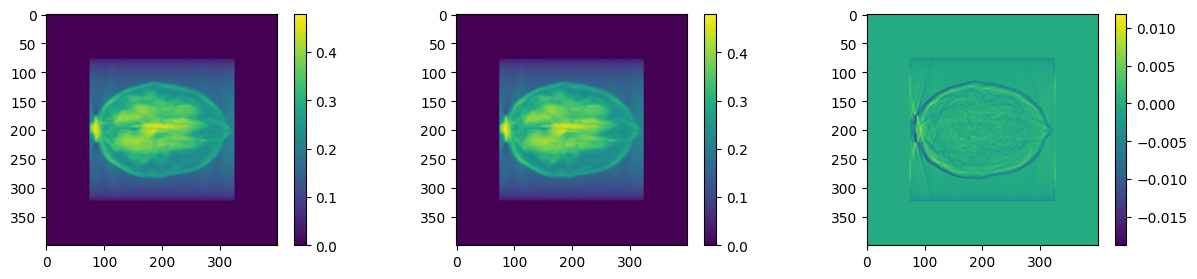

  6%|███████▏                                                                                                          | 1/16 [00:14<03:33, 14.26s/it]

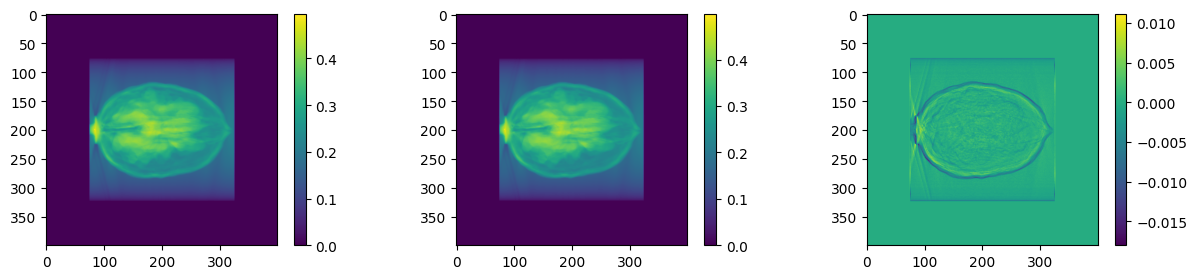

 12%|██████████████▎                                                                                                   | 2/16 [00:28<03:21, 14.40s/it]

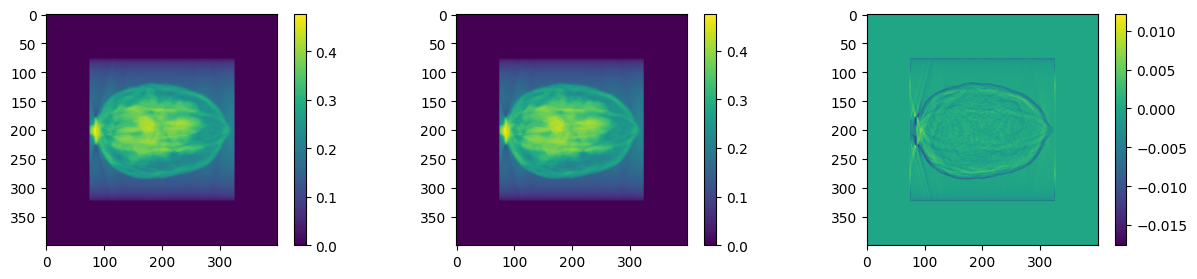

 19%|█████████████████████▍                                                                                            | 3/16 [00:43<03:09, 14.55s/it]

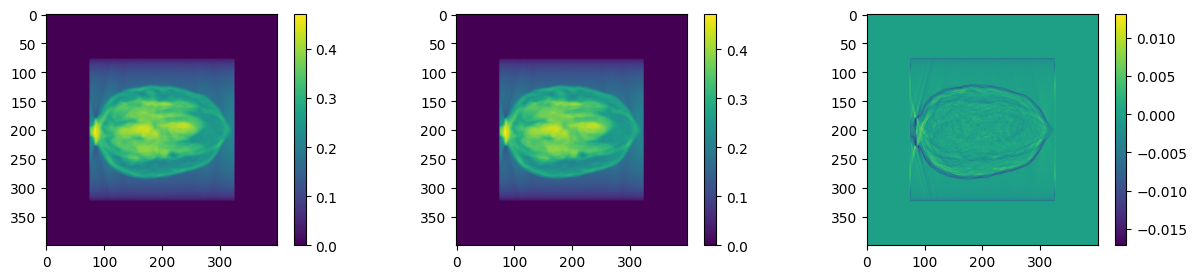

 25%|████████████████████████████▌                                                                                     | 4/16 [00:58<02:55, 14.65s/it]

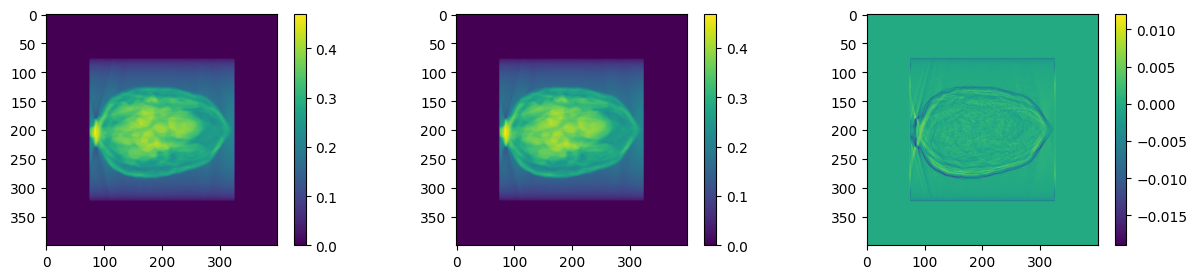

 31%|███████████████████████████████████▋                                                                              | 5/16 [01:13<02:42, 14.79s/it]

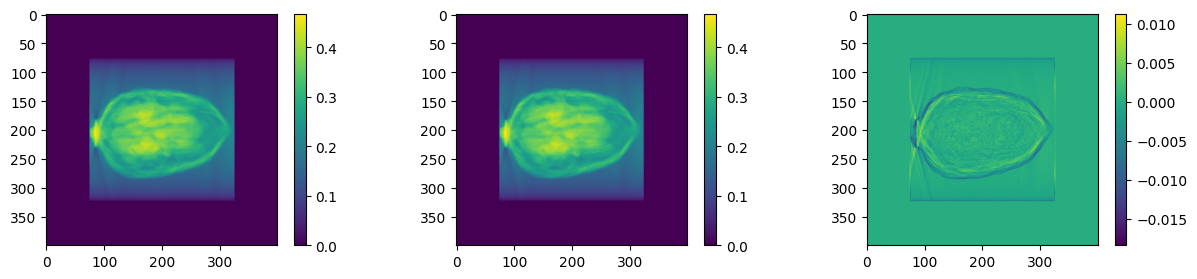

 38%|██████████████████████████████████████████▊                                                                       | 6/16 [01:28<02:27, 14.77s/it]

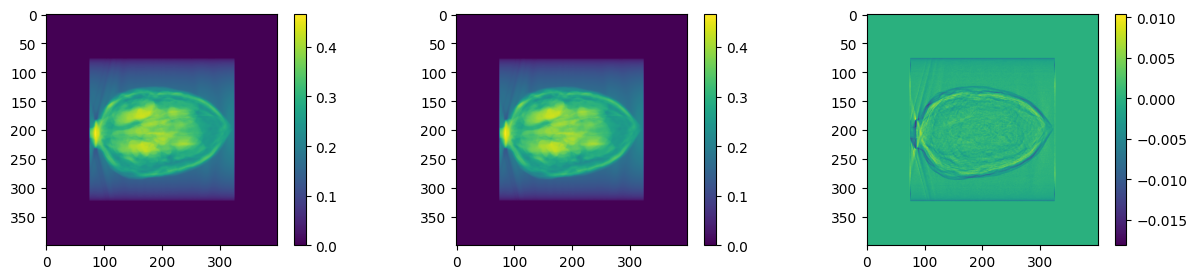

 44%|█████████████████████████████████████████████████▉                                                                | 7/16 [01:42<02:12, 14.71s/it]

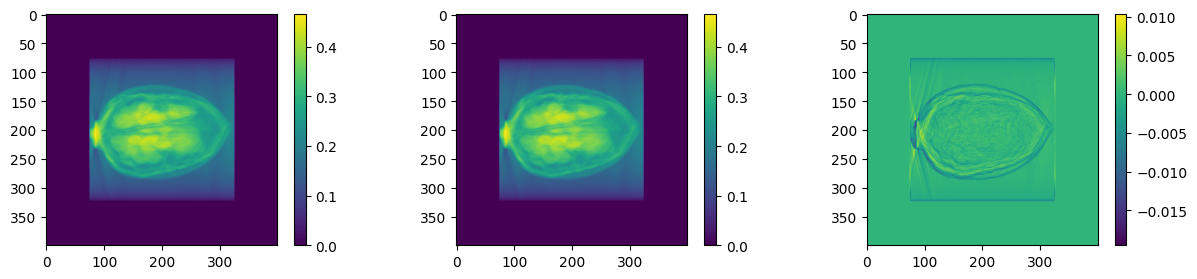

 50%|█████████████████████████████████████████████████████████                                                         | 8/16 [01:56<01:56, 14.58s/it]

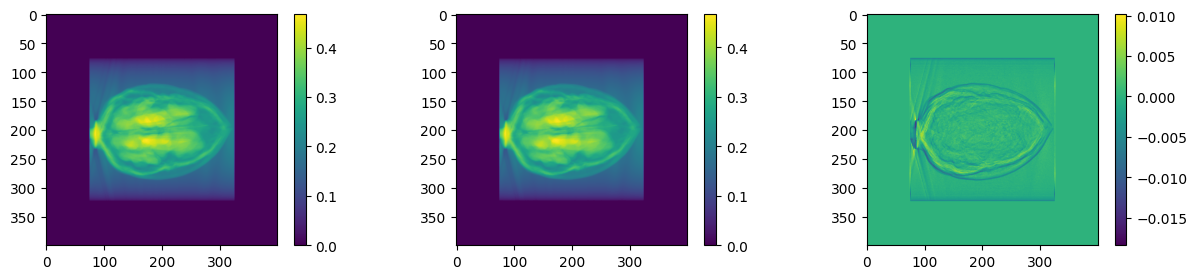

 56%|████████████████████████████████████████████████████████████████▏                                                 | 9/16 [02:11<01:41, 14.50s/it]

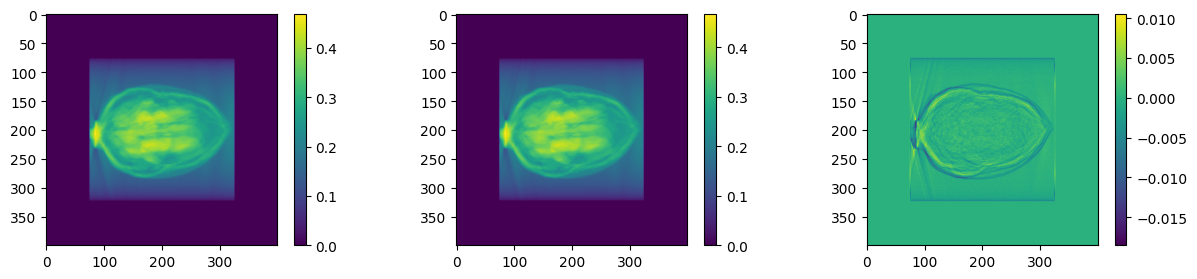

 62%|██████████████████████████████████████████████████████████████████████▋                                          | 10/16 [02:25<01:27, 14.53s/it]

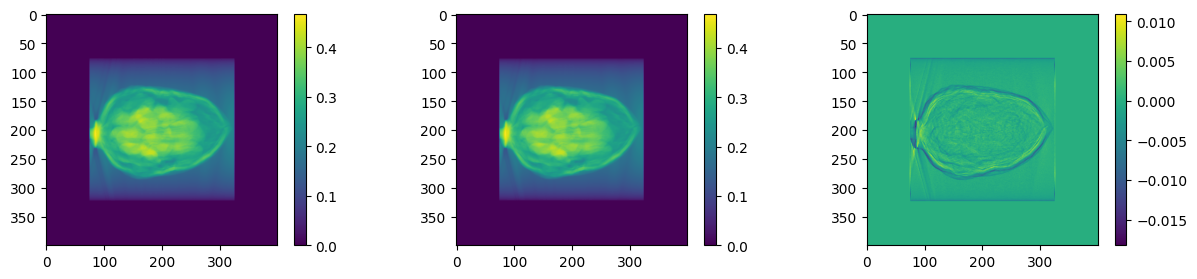

 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 11/16 [02:40<01:12, 14.60s/it]

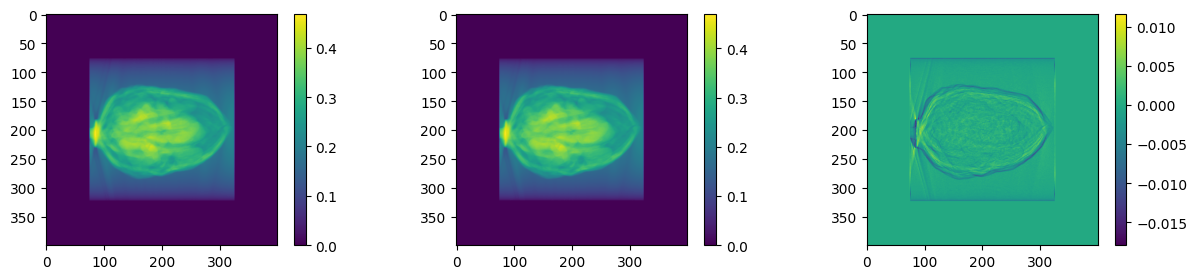

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 12/16 [02:55<00:59, 14.76s/it]

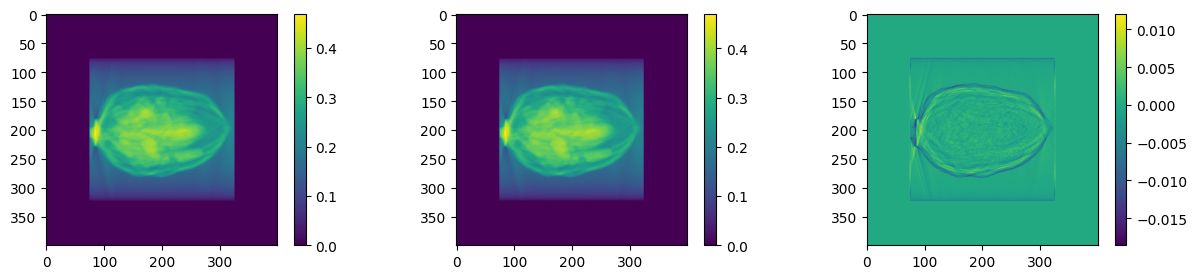

 81%|███████████████████████████████████████████████████████████████████████████████████████████▊                     | 13/16 [03:10<00:44, 14.79s/it]

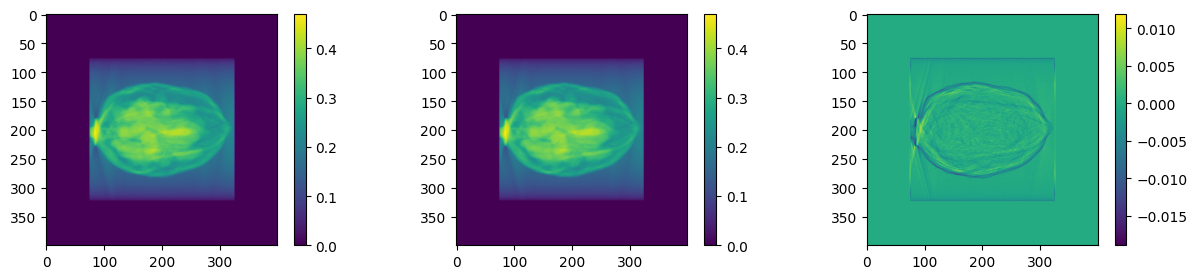

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉              | 14/16 [03:25<00:29, 14.78s/it]

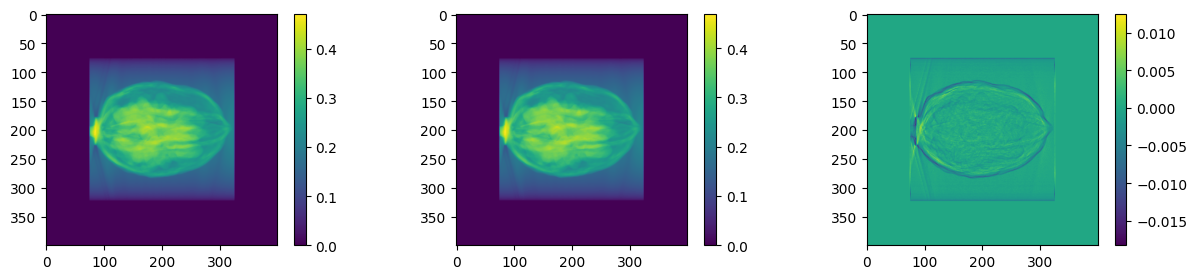

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 15/16 [03:39<00:14, 14.71s/it]

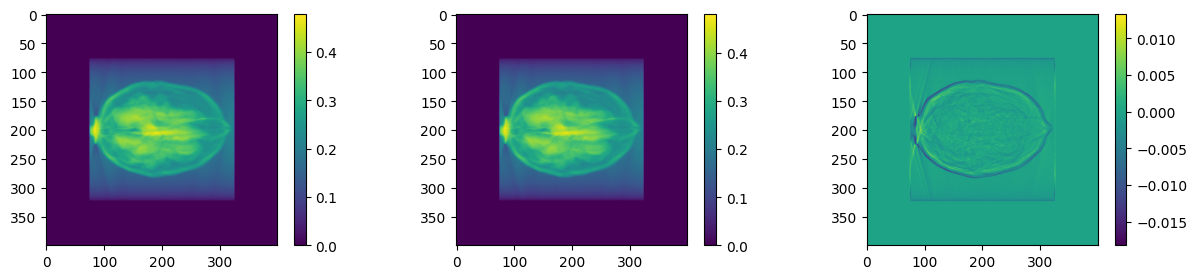

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:54<00:00, 14.64s/it]


In [41]:
img = datamodule.test_dataset.img.numpy()

grid = (np.linspace(0, img.shape[0]-1, img.shape[0]),np.linspace(0, img.shape[1]-1, img.shape[1]),np.linspace(0, img.shape[2]-1, img.shape[2]))
last_idx = 0
for i in tqdm(range(16)):
    projection_shape = datamodule.test_dataset.projections.shape
    valid_indices = datamodule.test_dataset.valid_indices
    valid_indices = valid_indices.view(projection_shape)
    next_idx = torch.sum(valid_indices[i])
    points = datamodule.test_dataset.points[last_idx:last_idx+next_idx,:,:]
    lengths = torch.linalg.norm((points[:,-1,:] - points[:,0,:]),dim=1)
    attenuation_values = scipy.interpolate.interpn(grid,img,(points*(img.shape[2]//2-0.5)+(img.shape[2]//2-0.5)),bounds_error=False,fill_value=0)
    
    pred = compute_projection_values(points.shape[1],torch.tensor(attenuation_values),lengths)
    detector_value_hat = np.zeros((img.shape[1],img.shape[1]))
    detector_value_hat[valid_indices[i]] = pred.numpy()

    last_idx += next_idx
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 3))
    mine = ax[0].imshow(detector_value_hat)
    astra = ax[1].imshow(datamodule.test_dataset.projections[i,:,:])
    diff = ax[2].imshow(datamodule.test_dataset.projections[i,:,:]-detector_value_hat)
    fig.colorbar(mine,ax=ax[0])
    fig.colorbar(astra,ax=ax[1])
    fig.colorbar(diff,ax=ax[2])
    plt.show()

  0%|                                                                                                                          | 0/16 [00:00<?, ?it/s]

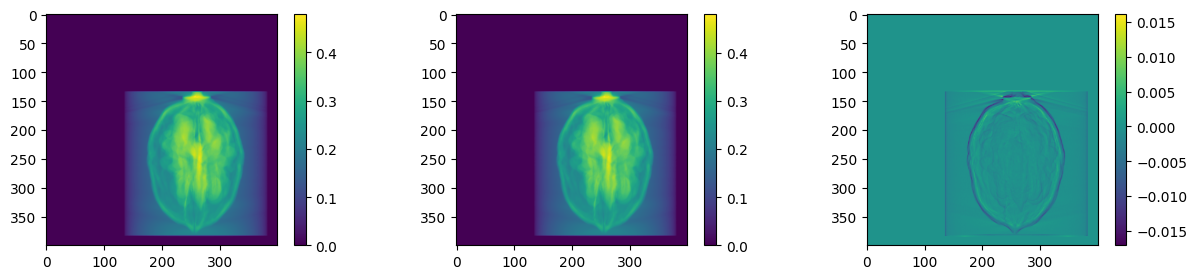

  6%|███████▏                                                                                                          | 1/16 [00:25<06:17, 25.16s/it]

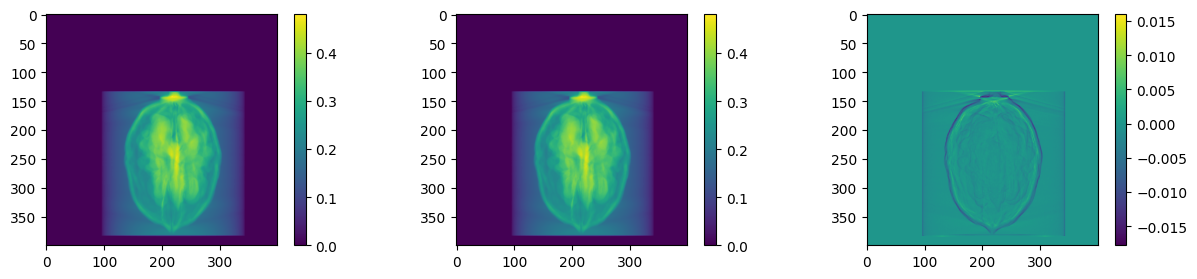

 12%|██████████████▎                                                                                                   | 2/16 [00:52<06:11, 26.56s/it]

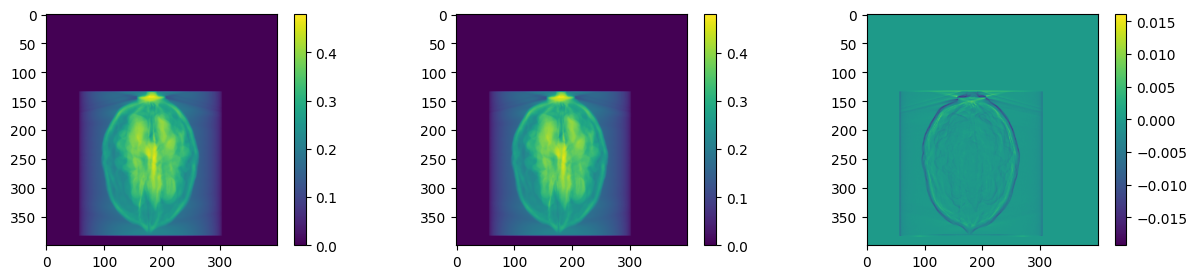

 19%|█████████████████████▍                                                                                            | 3/16 [01:20<05:49, 26.91s/it]

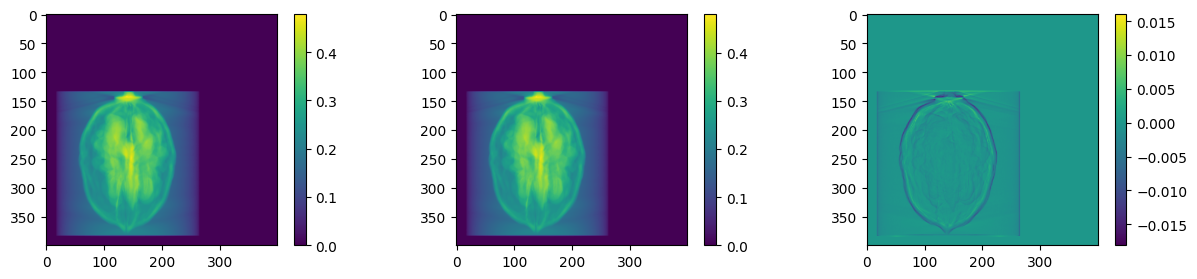

 25%|████████████████████████████▌                                                                                     | 4/16 [01:45<05:14, 26.21s/it]

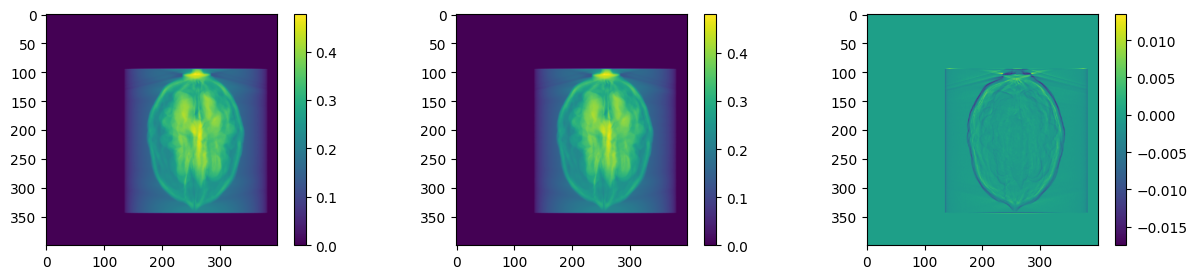

 31%|███████████████████████████████████▋                                                                              | 5/16 [02:12<04:54, 26.76s/it]

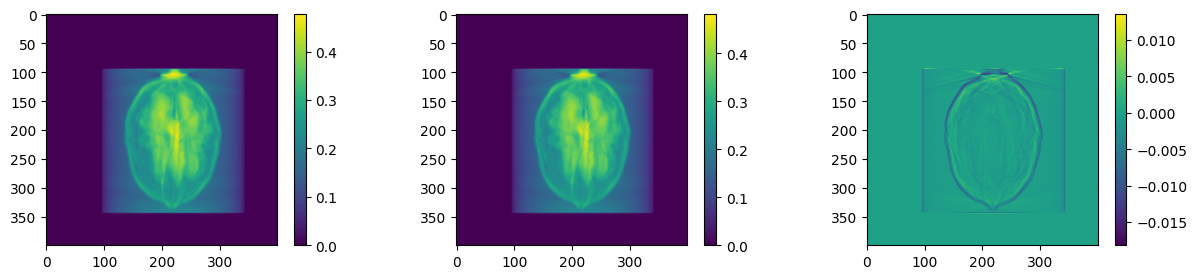

 38%|██████████████████████████████████████████▊                                                                       | 6/16 [02:42<04:37, 27.73s/it]

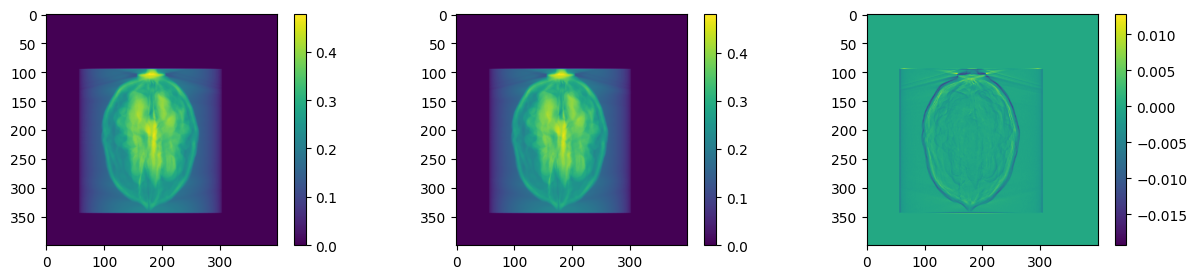

 44%|█████████████████████████████████████████████████▉                                                                | 7/16 [03:12<04:15, 28.36s/it]

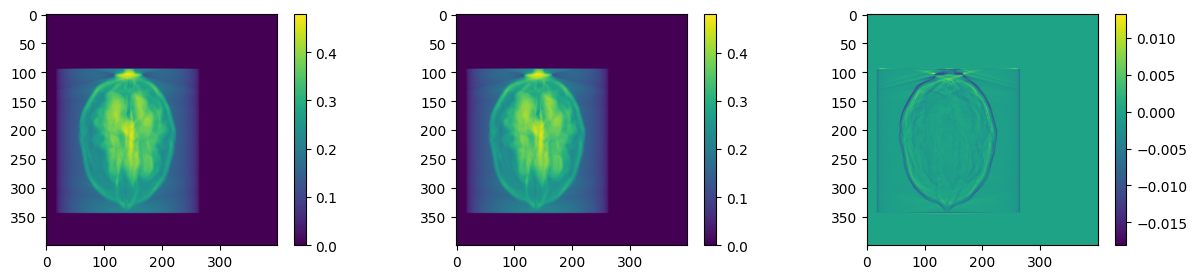

 50%|█████████████████████████████████████████████████████████                                                         | 8/16 [03:40<03:45, 28.19s/it]

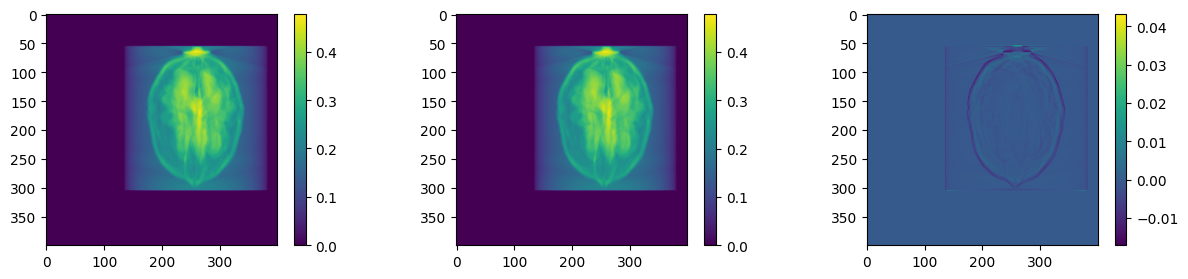

 56%|████████████████████████████████████████████████████████████████▏                                                 | 9/16 [04:09<03:20, 28.61s/it]

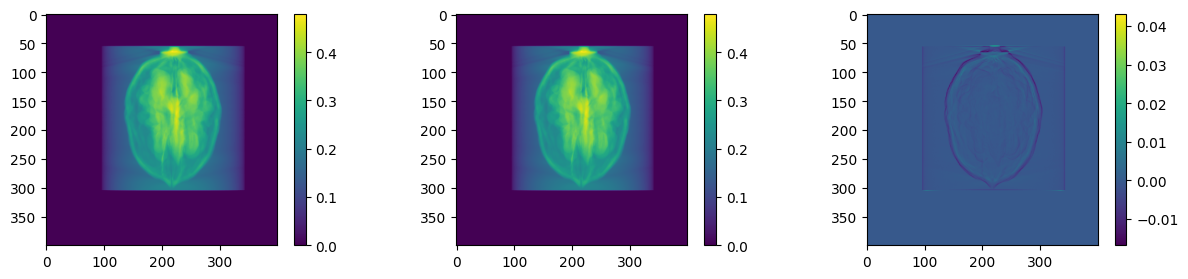

 62%|██████████████████████████████████████████████████████████████████████▋                                          | 10/16 [04:39<02:53, 28.90s/it]

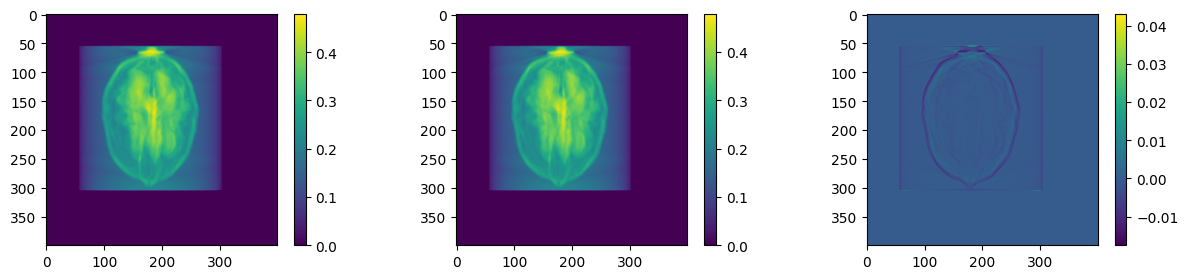

 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 11/16 [05:08<02:25, 29.11s/it]

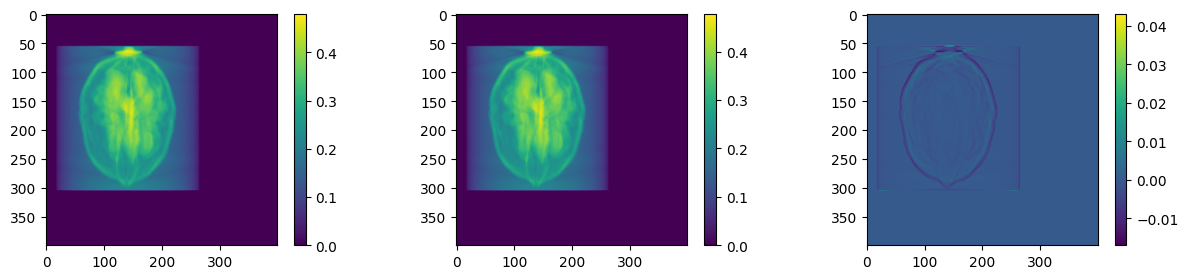

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 12/16 [05:36<01:54, 28.71s/it]

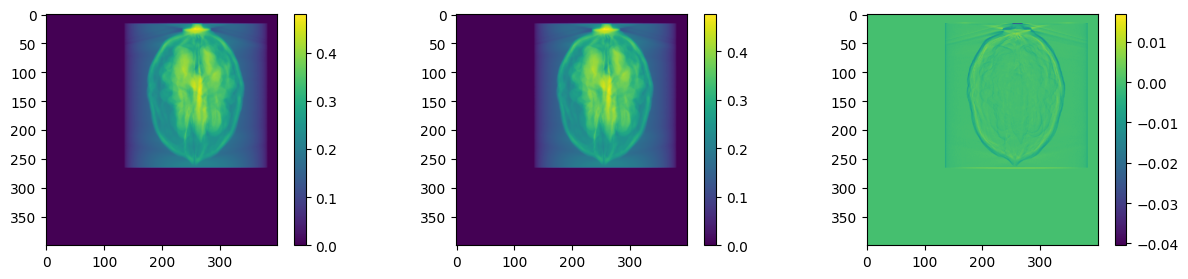

 81%|███████████████████████████████████████████████████████████████████████████████████████████▊                     | 13/16 [06:01<01:22, 27.60s/it]

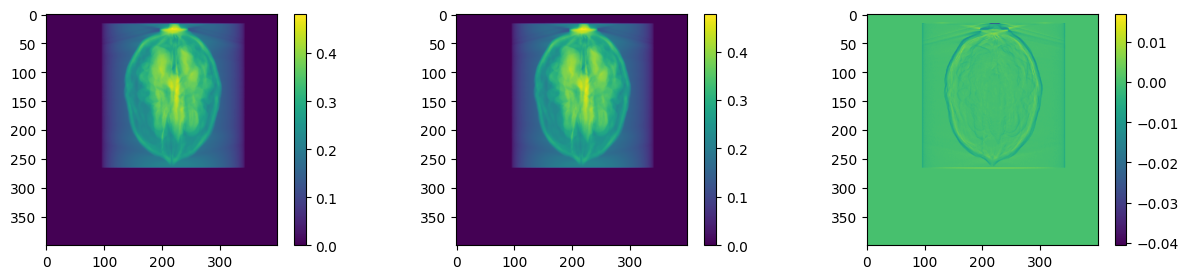

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉              | 14/16 [06:28<00:54, 27.46s/it]

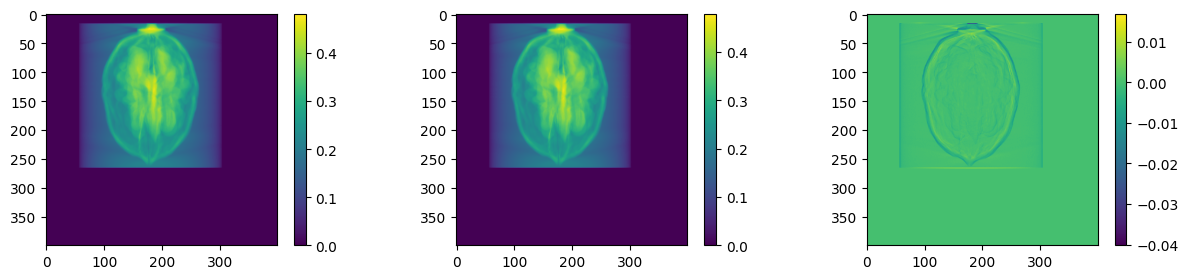

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 15/16 [06:56<00:27, 27.48s/it]

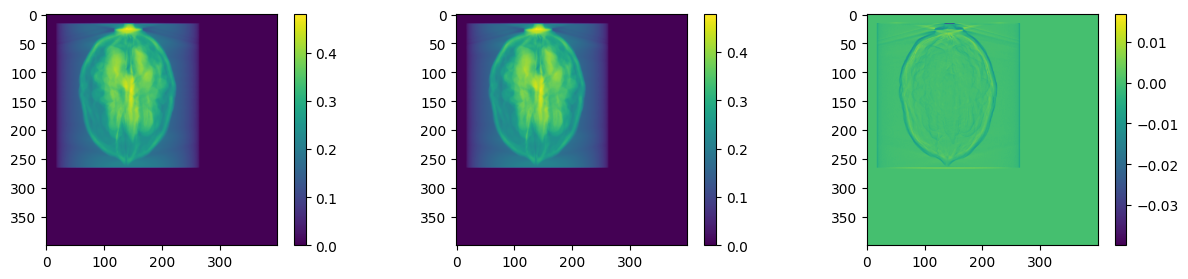

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [07:21<00:00, 27.58s/it]


In [42]:
args_dict = {
    "general": {
        "experiment_name": "test",
        "data_path":f'{_PATH_DATA}/walnut_plenoptic/walnut',
        "seed":42,
        "checkpoint_path":None,
        
    },
    "training": {
        "num_epochs": 1,
        "batch_size": 10,
        "learning_rate":1e-4,
        "device":get_device().type,
        "num_workers":0,
        "num_points":512,
        "imagefit_mode":False,
        "noisy_points":True,
        "regularization_weight":1e-1,
        "noisy_data":False,
        "noise_std":0
    },
    "model": { 
        "model_type": "mlp",
        "num_hidden_layers": 4,
        "num_hidden_features": 256,
        "num_freq_bands": 6,
        "activation_function": 'sine',
    },
}
datamodule = CTDataModule(args_dict)
datamodule.setup("test")

img = datamodule.test_dataset.img.numpy()

grid = (np.linspace(0, img.shape[0]-1, img.shape[0]),np.linspace(0, img.shape[1]-1, img.shape[1]),np.linspace(0, img.shape[2]-1, img.shape[2]))
last_idx = 0
for i in tqdm(range(16)):
    projection_shape = datamodule.test_dataset.projections.shape
    valid_indices = datamodule.test_dataset.valid_indices
    valid_indices = valid_indices.view(projection_shape)
    next_idx = torch.sum(valid_indices[i])
    points = datamodule.test_dataset.points[last_idx:last_idx+next_idx,:,:]
    lengths = torch.linalg.norm((points[:,-1,:] - points[:,0,:]),dim=1)
    attenuation_values = scipy.interpolate.interpn(grid,img,(points*(img.shape[2]//2-0.5)+(img.shape[2]//2-0.5)),bounds_error=False,fill_value=0)
    
    pred = compute_projection_values(points.shape[1],torch.tensor(attenuation_values),lengths)
    detector_value_hat = np.zeros((img.shape[1],img.shape[1]))
    detector_value_hat[valid_indices[i]] = pred.numpy()

    last_idx += next_idx
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 3))
    mine = ax[0].imshow(detector_value_hat)
    astra = ax[1].imshow(datamodule.test_dataset.projections[i,:,:])
    diff = ax[2].imshow(datamodule.test_dataset.projections[i,:,:]-detector_value_hat)
    fig.colorbar(mine,ax=ax[0])
    fig.colorbar(astra,ax=ax[1])
    fig.colorbar(diff,ax=ax[2])
    plt.show()

# Test trained model

In [16]:
import numpy as np
import tifffile
from tqdm import tqdm
import scipy.ndimage as ndi

import torch
import torch._dynamo

from src.dataloaders import CTDataModule
from src.models.mlp import MLP
from src import get_device, _PATH_DATA, _PATH_MODELS
import matplotlib.pyplot as plt

args_dict = {
    "general": {
        "experiment_name": "test",
        "data_path":f'{_PATH_DATA}/walnut_small_angle/walnut_small',
        "seed":42,
        "checkpoint_path":None,
        
    },
    "training": {
        "num_epochs": 1,
        "batch_size": 10,
        "learning_rate":1e-4,
        "device":get_device().type,
        "num_workers":0,
        "num_points":256,
        "imagefit_mode":False,
        "noisy_points":False,
        "regularization_weight":1e-1,
        "noisy_data":False,
        "noise_std":0,
        
    },
    "model": { 
        "model_type": "mlp",
        "num_hidden_layers": 4,
        "num_hidden_features": 256,
        "num_freq_bands": 6,
        "activation_function": 'sine',
    },
}

In [2]:
# datamodule = CTDataModule(args_dict)
# datamodule.setup()
# loader = datamodule.dataloader_for_testing()

In [3]:
projection_shape = np.load(f"{args_dict['general']['data_path']}_projections.npy").shape
model = MLP(args_dict, 
            projection_shape=projection_shape[::2]
           ).to(args_dict['training']['device'])

checkpoint_path = f"{_PATH_MODELS}/walnut_small_many_angles-2024-07-09-2135/MLP-epoch=94.ckpt"
model.load_state_dict(torch.load(checkpoint_path, map_location=None)['state_dict'], strict=True)
model.eval();
model.cuda();

/tmp/ipykernel_25735/1906852068.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=None)['state_dict'], stric

In [4]:
img = torch.tensor(tifffile.imread(f"{args_dict['general']['data_path']}.tif"))
img -= img.min()
img = img/img.max()
img = img.permute(2,1,0)
tifffile.imwrite("real_img.tif",(img.numpy()*255).astype("uint8"))

In [84]:
# mgrid = torch.stack(torch.meshgrid(torch.linspace(-1, 1, img.shape[0]), torch.linspace(-1, 1, img.shape[1]), torch.linspace(-1, 1, img.shape[2]), indexing='ij'),dim=-1)
mgrid = torch.stack(torch.meshgrid(torch.linspace(-1-(1/img.shape[0]), 1-(1/img.shape[0]), img.shape[0]), torch.linspace(-1-(1/img.shape[0]), 1-(1/img.shape[0]), img.shape[0]), torch.linspace(-1-(1/img.shape[0]), 1-(1/img.shape[0]), img.shape[0]), indexing='ij'),dim=-1)

mgrid = mgrid.view(-1,img.shape[2],3)
outputs = torch.zeros((*mgrid.shape[:2],1))
for i in tqdm(range(mgrid.shape[1])):
    with torch.no_grad():
        output = model(mgrid[:,i,:].cuda())
    outputs[:,i,:] = output.cpu()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 569.41it/s]


In [85]:
outputs = outputs.view(img.shape)

In [86]:
print(outputs.min())
print(outputs.max())

tensor(0.)
tensor(0.7985)


In [67]:
outputs -= outputs.min()
outputs /= outputs.max()

In [90]:
tifffile.imwrite("reconstruction_mlp.tif",(outputs.numpy()*255).astype("uint8"))

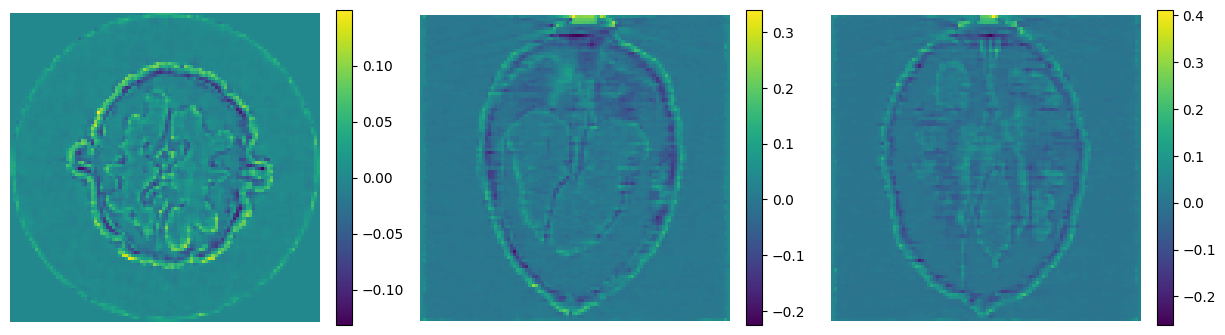

In [95]:
residual = img[1:] - outputs[1:]
# residual = img - outputs
fig, ax = plt.subplots(1,3,figsize=(15,15))
slice1 = ax[0].imshow(residual[50,:,:])
plt.colorbar(slice1, ax=ax[0],fraction=0.046)
slice2 = ax[1].imshow(residual[:,50,:])
plt.colorbar(slice2, ax=ax[1],fraction=0.046)
slice3 = ax[2].imshow(residual[:,:,50])
plt.colorbar(slice3, ax=ax[2],fraction=0.046)
for i in range(3):
    ax[i].axis("off")

plt.show()

# Testing

In [10]:
import tifffile
import numpy as np
from tqdm import tqdm
import scipy
import torch
import matplotlib.pyplot as plt
from glob import glob
import os

from src.dataloaders import CTDataModule
from src.models.mlp import MLP, compute_projection_values
from src import get_device, _PATH_DATA, _PATH_MODELS

from mpl_toolkits.mplot3d import Axes3D

# Args dict used to organise the arguments
args_dict = {
    "general": {
        "experiment_name": "test",
        "data_path":f'{_PATH_DATA}/walnut_small_angle/walnut_small',
        "seed":42,
        "checkpoint_path":None,
        
    },
    "training": {
        "num_epochs": 1,
        "batch_size": 100,
        "learning_rate":1e-4,
        "device":get_device().type,
        "num_workers":0,
        "num_points":256,
        "imagefit_mode":False,
        "noisy_points":False,
        "regularization_weight":1e-1,
        "noisy_data":False,
        "noise_std":0
    },
    "model": { 
        "model_type": "mlp",
        "num_hidden_layers": 4,
        "num_hidden_features": 256,
        "num_freq_bands": 6,
        "activation_function": 'sine',
    },
}

In [11]:
datamodule = CTDataModule(args_dict)
datamodule.setup("test")

Generating points from rays: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 26.23it/s]


In [16]:
dataloader = datamodule.test_dataloader()
iterator = iter(dataloader)

In [88]:
batch = next(iterator)
batch[1]

tensor([0.1142, 0.1144, 0.1139, 0.1138, 0.1136, 0.1139, 0.1145, 0.1140, 0.1142,
        0.1145, 0.1140, 0.1139, 0.1141, 0.1133, 0.1138, 0.1139, 0.1139, 0.1138,
        0.1130, 0.1131, 0.1127, 0.1126, 0.1124, 0.1117, 0.1114, 0.1123, 0.1132,
        0.1145, 0.1160, 0.1167, 0.1154, 0.1146, 0.1119, 0.1093, 0.1101, 0.1120,
        0.1143, 0.1160, 0.1175, 0.1183, 0.1191, 0.1196, 0.1193, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.1082, 0.1086, 0.1075, 0.1058, 0.1044,
        0.1011, 0.1016, 0.0996, 0.1074, 0.1092, 0.1084, 0.1068, 0.1032, 0.1009,
        0.1017, 0.1031, 0.1033, 0.1042, 0.1042, 0.1048, 0.1049, 0.1045, 0.1045,
        0.1044])

In [14]:
batch = [item.to("cuda") for item in batch]

In [6]:
projection_shape = np.load(f"{args_dict['general']['data_path']}_projections.npy").shape
model = MLP(args_dict, 
            projection_shape=projection_shape[::2]
           ).to(args_dict['training']['device'])

In [7]:
loss = model.training_step(batch,0)

/work3/s164564/envs/renner/lib/python3.10/site-packages/pytorch_lightning/core/module.py:447: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


In [8]:
loss

tensor(0.0103, device='cuda:0', grad_fn=<AddBackward0>)

In [6]:
import os

import torch
import numpy as np
import pytorch_lightning as pl

from tqdm import tqdm
from glob import glob
from tifffile import tifffile
from torch.utils.data import DataLoader

from src import _PATH_DATA

In [7]:
class Geometry(torch.nn.Module):
    def __init__(self,source_pos,detector_pos,detector_size,detector_pixel_size,object_shape,beam_type="cone"):
        """
        Parameters
        ----------
        source_pos : torch.Tensor
            ray source position x,y,z position in relation to sample
        detector_pos : torch.Tensor
            center of detector x,y,z position in relation to sample
        detector_size : Sequence[int]
            Shape of detector in pixels e.g. (300,300)
        detector_pixel_size : Sequence[torch.Tensor]
            Two vectors defining the size of the pixels 
            u : the vector from detector pixel (0,0) to (0,1)
            v : the vector from detector pixel (0,0) to (1,0)
        object_shape: Sequence[int]
            shape of object in um, i.e. an object which has the dimensions 200x200x300um has the shape [200,200,300]
        beam_type : str
            Which beam type to use for calculating projection. Default 'cone'
        """
        super(Geometry, self).__init__()
        self.source_pos = source_pos
        self.detector_pos = detector_pos
        self.detector_size = detector_size
        self.detector_pixel_size = detector_pixel_size
        self.u_vec = detector_pixel_size[:3]
        self.v_vec = detector_pixel_size[3:]
        self.beam_type = beam_type
        self.object_shape = object_shape

        # Convert into relative coordinates 
        self.source_pos[0] /= self.object_shape[0]/2
        self.source_pos[1] /= self.object_shape[1]/2
        self.source_pos[2] /= self.object_shape[2]/2
        
        self.detector_pos[0] /= self.object_shape[0]/2
        self.detector_pos[1] /= self.object_shape[1]/2
        self.detector_pos[2] /= self.object_shape[2]/2
        
        self.u_vec[0] /= self.object_shape[0]/2
        self.u_vec[1] /= self.object_shape[1]/2
        self.u_vec[2] /= self.object_shape[2]/2

        self.v_vec[0] /= self.object_shape[0]/2
        self.v_vec[1] /= self.object_shape[1]/2
        self.v_vec[2] /= self.object_shape[2]/2
        

        self.detector_pixel_coordinates = self.create_grid(self.detector_pos, self.u_vec, self.v_vec, self.detector_size[0],self.detector_size[1])
        
        self.ray_directions()

        self.start_points, self.end_points, self.valid_indices = self.ray_sphere_intersections(self.source_pos.repeat(self.detector_size[0]*self.detector_size[1]).view(-1,3),self.rays.view(-1,3),torch.zeros(3),torch.sqrt(torch.tensor(3.)))

        self.start_points = self.start_points[self.valid_indices]
        self.end_points = self.end_points[self.valid_indices]
        # self.start_points[~self.valid_indices] = self.source_pos
        # self.end_points[~self.valid_indices] = self.detector_pixel_coordinates.view(-1,3)[~self.valid_indices]
    
    def ray_directions(self):
        self.rays = (self.detector_pixel_coordinates - self.source_pos)
        lengths = torch.linalg.norm(self.rays,dim=2)
        self.rays[:,:,0] = self.rays[:,:,0] / lengths
        self.rays[:,:,1] = self.rays[:,:,1] / lengths
        self.rays[:,:,2] = self.rays[:,:,2] / lengths

    def ray_sphere_intersections(self,ray_origins, ray_directions, sphere_center, sphere_radius):
        """
        Calculates the intersection points between rays and a sphere using PyTorch tensors.
        
        Args:
            ray_origins (torch.Tensor): Tensor of 3D coordinates of ray origins (shape: (n, 3)).
            ray_directions (torch.Tensor): Tensor of 3D vectors representing ray directions (shape: (n, 3)).
            sphere_center (torch.Tensor): 3D coordinates of the sphere center.
            sphere_radius (float): Radius of the sphere.
        
        Returns:
            torch.Tensor: Intersection points for each ray (shape: (n, 3)).
        """
        # Compute vector from ray origins to sphere center
        oc = ray_origins - sphere_center
        
        # Compute discriminant
        a = torch.sum(ray_directions**2, dim=1)
        b = 2.0 * torch.sum(oc * ray_directions, dim=1)
        c = torch.sum(oc**2, dim=1) - sphere_radius**2
        discriminant = b**2 - 4*a*c
        
        # Initialize intersection points tensor
        start_points = torch.zeros_like(ray_origins)
        end_points = torch.zeros_like(ray_origins)
        
        # Calculate intersection points for rays with non-negative discriminant
        valid_indices = discriminant >= 0
        t1 = (-b[valid_indices] - torch.sqrt(discriminant[valid_indices])) / (2*a[valid_indices])
        t2 = (-b[valid_indices] + torch.sqrt(discriminant[valid_indices])) / (2*a[valid_indices])
        start_points[valid_indices] = ray_origins[valid_indices] + t1[:, None] * ray_directions[valid_indices]
        end_points[valid_indices] = ray_origins[valid_indices] + t2[:, None] * ray_directions[valid_indices]
        return start_points, end_points, valid_indices

    def create_grid(self,detector_pos, u_vec, v_vec, u_size,v_size):
        # Initialize the grid
        detector_pixels = torch.zeros((u_size, v_size, 3), dtype=torch.double)
    
        # Calculate the starting point of the grid
        start_pos = detector_pos - (u_size//2)*u_vec - (v_size//2)*v_vec + u_vec/2 + v_vec/2
    
        # Create ranges for u and v
        u_range = torch.arange(u_size).view(-1, 1, 1).double()
        v_range = torch.arange(v_size).view(1, -1, 1).double()
    
        # Fill the grid using broadcasting and vectorized operations
        detector_pixels = start_pos + u_range * u_vec + v_range * v_vec
    
        return detector_pixels
    
    def sample_points(self, num_points):
        """
        Parameters
        ----------
        num_points : int
            Number of points sampled per ray 
        """
        # Compute the step size for each ray by dividing the total distance by the number of points
        step_size = (self.end_points - self.start_points) / num_points
    
        # Create a tensor 'steps' of shape (num_points+1, 1, 1)
        # This tensor represents the step indices for each point along the ray
        steps = torch.arange(num_points + 1).unsqueeze(-1).unsqueeze(-1)
    
        # Compute the coordinates of each point along the ray by adding the start point to the product of the step size and the step indices
        # This uses broadcasting to perform the computation for all points and all rays at once
        points = self.start_points + step_size * steps
    
        # Permute the dimensions of the points tensor to match the expected output shape
        return points.permute(1,0,2), step_size

In [9]:
args_dict = {
    "general": {
        "experiment_name": "test",
        "data_path":f'{_PATH_DATA}/walnut_small_angle/walnut_small',
        "seed":42,
        "checkpoint_path":None,
        
    },
    "training": {
        "num_epochs": 1,
        "batch_size": 10,
        "learning_rate":1e-4,
        "device":"cuda",
        "num_workers":0,
        "num_points":256,
        "imagefit_mode":False,
        "noisy_points":False,
        "regularization_weight":1e-1,
        "noisy_data":False,
        "noise_std":0,
        
    },
    "model": { 
        "model_type": "mlp",
        "num_hidden_layers": 4,
        "num_hidden_features": 256,
        "num_freq_bands": 6,
        "activation_function": 'sine',
    },
}

In [29]:
import dask.array as da
import zarr

In [10]:

data_path = args_dict['general']['data_path'] 

positions = np.load(f"{data_path}_positions.npy")
projections = np.load(f"{data_path}_projections.npy")


img = torch.tensor(tifffile.imread(f"{args_dict['general']['data_path']}.tif"))
img -= img.min()
img = img/img.max()
img = img.permute(2,1,0)



detector_size = projections[0,:,:].shape
detector_pos = torch.tensor(positions[:,3:6])
detector_pixel_size = torch.tensor(positions[:,6:])

source_pos = torch.tensor(positions[:,:3])
object_shape = img.shape

points = [None]*positions.shape[0]
step_sizes = [None]*positions.shape[0]
valid_indices = [None]*positions.shape[0]

for i in tqdm(range(positions.shape[0]),desc='Generating points from rays'):
    geometry = Geometry(source_pos[i],detector_pos[i],detector_size,detector_pixel_size[i],object_shape)
    points[i], step_sizes[i] = geometry.sample_points(args_dict['training']['num_points'])
    valid_indices[i] = geometry.valid_indices

points = torch.cat(points).view(-1,args_dict['training']['num_points']+1,3)
step_sizes = torch.cat(step_sizes).view(-1,3)
valid_indices = torch.cat(valid_indices)
lengths = torch.linalg.norm((points[:,-1,:] - points[:,0,:]),dim=1)

Generating points from rays: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.68it/s]


In [62]:
torch.save(valid_indices, "test_data/100x100_100-angles.zarr/valid_indices.pt")

In [15]:
points = points.to(torch.float16)
step_sizes = step_sizes.to(torch.float16)
lengths = lengths.to(torch.float16)

In [46]:
points_dask = da.from_array(points.numpy(),chunks=(1000,args_dict['training']['num_points']+1,3))

In [47]:
points_dask

dask.array<array, shape=(874400, 257, 3), dtype=float16, chunksize=(1000, 257, 3), chunktype=numpy.ndarray>

In [49]:
da.to_zarr(points_dask, "test_data/100x100_100-angles.zarr",component="points", compute=True)

In [51]:
step_sizes_dask = da.from_array(step_sizes.numpy(),chunks=(1000,3))

In [52]:
step_sizes_dask

dask.array<array, shape=(874400, 3), dtype=float16, chunksize=(1000, 3), chunktype=numpy.ndarray>

In [55]:
da.to_zarr(step_sizes_dask, "test_data/100x100_100-angles.zarr",component="step_sizes", compute=True)

In [54]:
lengths_dask = da.from_array(lengths.numpy(),chunks=(1000,))
lengths_dask

dask.array<array, shape=(874400,), dtype=float16, chunksize=(1000,), chunktype=numpy.ndarray>

In [56]:
da.to_zarr(lengths_dask, "test_data/100x100_100-angles.zarr",component="lengths", compute=True)

In [37]:
points_dask = da.from_zarr("test_data/100x100_100-angles.zarr",component="points")

In [43]:
temp = points_dask[[1,2,8,900],:,:].compute()

In [57]:
help(da.from_zarr)

Help on function from_zarr in module dask.array.core:

from_zarr(url, component=None, storage_options=None, chunks=None, name=None, inline_array=False, **kwargs)
    Load array from the zarr storage format
    
    See https://zarr.readthedocs.io for details about the format.
    
    Parameters
    ----------
    url: Zarr Array or str or MutableMapping
        Location of the data. A URL can include a protocol specifier like s3://
        for remote data. Can also be any MutableMapping instance, which should
        be serializable if used in multiple processes.
    component: str or None
        If the location is a zarr group rather than an array, this is the
        subcomponent that should be loaded, something like ``'foo/bar'``.
    storage_options: dict
        Any additional parameters for the storage backend (ignored for local
        paths)
    chunks: tuple of ints or tuples of ints
        Passed to :func:`dask.array.from_array`, allows setting the chunks on
        initia

In [63]:
points_dask = da.from_zarr("../data/walnut_small_angle/100x100_100-angles.zarr",component="points")
step_sizes_dask = da.from_zarr("../data/walnut_small_angle/100x100_100-angles.zarr",component="step_sizes")
lengths_dask = da.from_zarr("../data/walnut_small_angle/100x100_100-angles.zarr",component="lengths")


In [66]:
points_dask.shape[0]

874400

In [67]:
idx = [1,2,3,4,5,6]

In [69]:
points = torch.tensor(points_dask[idx,:,:].compute()).view(-1,3)
step_size = torch.tensor(step_sizes_dask[idx,:].compute())
length = torch.tensor(lengths_dask[idx].compute())

In [70]:
points.shape

torch.Size([1542, 3])

In [ ]:
class CTpoints(torch.utils.data.Dataset):
    def __init__(self, args_dict, noisy_points=False):

        self.args = args_dict
        data_path = self.args['general']['data_path'] 
        
        positions = np.load(f"{data_path}_positions.npy")
        self.projections = np.load(f"{data_path}_projections.npy")
        
        if self.args['training']['noisy_data']:
            self.projections += np.random.normal(loc=0,scale=self.args['training']['noise_std'],size=self.projections.shape)
            self.projections = np.clip(self.projections,0,1)
        
        img = torch.tensor(tifffile.imread(f"{args_dict['general']['data_path']}.tif"))
        img -= img.min()
        img = img/img.max()
        self.img = img.permute(2,1,0)
        if self.args['training']['imagefit_mode']:
            mgrid = torch.stack(torch.meshgrid(torch.linspace(-1, 1, self.img.shape[0]),
                                               torch.linspace(-1, 1, self.img.shape[1]),
                                               torch.linspace(-1, 1, self.img.shape[2]),
                                               indexing='ij'),
                                dim=-1)
            self.mgrid = mgrid.view(-1,self.img.shape[2],3)
        
        
        self.detector_size = self.projections[0,:,:].shape
        detector_pos = torch.tensor(positions[:,3:6])
        detector_pixel_size = torch.tensor(positions[:,6:])
        
        source_pos = torch.tensor(positions[:,:3])
        object_shape = self.img.shape
        
        
        self.valid_indices = torch.load(f"{data_path}/100x100_100-angles.zarr/valid_indices.pt")
        self.points = da.from_zarr("test_data/100x100_100-angles.zarr",component="points")
        self.step_sizes = da.from_zarr("test_data/100x100_100-angles.zarr",component="step_sizes")
        self.lengths = da.from_zarr("test_data/100x100_100-angles.zarr",component="lengths")
        

        self.noisy = noisy_points
    
    def __len__(self):
        if self.args['training']['imagefit_mode']:
            return self.img.shape[2]
        else:
            return self.points.shape[0]


    def __getitem__(self, idx):
        if self.args['training']['imagefit_mode']:
            points = self.mgrid[:,idx,:]
            targets = self.img[:,:,idx]
            length = None
        else:
            points_dask = 
            step_sizes_dask = 
            lengths_dask = 
            
            points = torch.tensor(self.points[idx,:,:].compute()).view(-1,3)
            targets = torch.tensor(self.projections.flatten()[self.valid_indices][idx])
            step_size = torch.tensor(self.step_sizes[idx,:,:].compute())
            length = torch.tensor(self.lengths[idx,:,:].compute())

            if self.noisy:
                noise = torch.zeros_like(step_size)
                noise = (torch.rand(noise.shape)-0.5)*0.5
                points = points+(noise*step_size)[None,:]
                
        return points,targets,length

In [1]:
import tifffile
import numpy as np
from tqdm import tqdm
import scipy
import torch
import matplotlib.pyplot as plt
from glob import glob
import os

from src.dataloaders import CTDataModule
from src.models.mlp import MLP, compute_projection_values
from src import get_device, _PATH_DATA, _PATH_MODELS

# Args dict used to organise the arguments
args_dict = {
    "general": {
        "experiment_name": "test",
        "data_path":f'{_PATH_DATA}/walnut_small_angle/walnut_small',
        "seed":42,
        "checkpoint_path":None,
        
    },
    "training": {
        "num_epochs": 1,
        "batch_size": 100,
        "learning_rate":1e-4,
        "device":get_device().type,
        "num_workers":0,
        "num_points":256,
        "imagefit_mode":False,
        "noisy_points":False,
        "regularization_weight":1e-1,
        "noisy_data":False,
        "noise_std":0
    },
    "model": { 
        "model_type": "mlp",
        "num_hidden_layers": 4,
        "num_hidden_features": 256,
        "num_freq_bands": 6,
        "activation_function": 'sine',
    },
}

In [2]:
datamodule = CTDataModule(args_dict)
datamodule.setup("test")

Generating points from rays: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.12it/s]


In [3]:
dataloader = datamodule.test_dataloader()

In [4]:
dataloader.dataset.noisy = True

In [5]:
dataloader.dataset.__getitems__([0,1,2,3])

torch.Size([4, 257, 3])
torch.Size([4, 3])
torch.Size([4, 257, 3])


(tensor([[[-0.6885,  1.5859, -0.1068],
          [-0.6885,  1.5859, -0.1062],
          [-0.6885,  1.5859, -0.1053],
          ...,
          [-0.6890,  1.5859,  0.0953],
          [-0.6890,  1.5859,  0.0960],
          [-0.6890,  1.5859,  0.0970]],
 
         [[-0.6567,  1.5850, -0.2358],
          [-0.6567,  1.5850, -0.2346],
          [-0.6567,  1.5850, -0.2324],
          ...,
          [-0.6572,  1.5869,  0.2231],
          [-0.6572,  1.5869,  0.2241],
          [-0.6572,  1.5869,  0.2263]],
 
         [[-0.6245,  1.5850, -0.3127],
          [-0.6245,  1.5850, -0.3096],
          [-0.6245,  1.5850, -0.3071],
          ...,
          [-0.6250,  1.5869,  0.2976],
          [-0.6250,  1.5869,  0.3003],
          [-0.6250,  1.5869,  0.3022]],
 
         [[-0.5923,  1.5850, -0.3706],
          [-0.5923,  1.5850, -0.3677],
          [-0.5923,  1.5850, -0.3640],
          ...,
          [-0.5933,  1.5869,  0.3552],
          [-0.5933,  1.5869,  0.3577],
          [-0.5933,  1.5869,  0.36

In [6]:
points,targets,length =  dataloader.dataset.__getitems__([0,1,2,3])

torch.Size([4, 257, 3])
torch.Size([4, 3])
torch.Size([4, 257, 3])


In [8]:
torch.linalg.norm((points[:,-1,:] - points[:,0,:]),dim=1)

tensor([0.2035, 0.4629, 0.6147, 0.7314], dtype=torch.float16)

In [10]:
length

tensor([0.2037, 0.4626, 0.6147, 0.7310], dtype=torch.float16)

In [2]:
252/24

10.5